In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

Other potential data sources:

Somewhat irregularly collected data from Georgia universities
https://docs.google.com/document/d/1tCijdezYBswB6fjFZcLPxalbRBolAR9DDOLjBjc-oaM/edit
        
SUNY maintains one dashboard for all 64 campuses.  maybe we can scrape it?
https://www.suny.edu/covid19-tracker/

Before running this, do a git pull on `../../college-covid19-dataset` (the big10 repo)

In [18]:
nyt_datapath = '../UniversityCases/'
big10_datapath = '../../college-covid19-dataset/data'

### Import and Clean Data

New York Times - All Schools

In [19]:
fnames = sorted(glob.glob(nyt_datapath+'*.csv'))
frames = []
for f in fnames:
    m = re.search(r'[^0-9]*([0-9][0-9_]+)[^0-9]*', f)
    df = pd.read_csv(f)
    df['Date'] = pd.to_datetime(m.group(1), format='%m_%d_%y')
    df.drop(['Unnamed: 0'], axis = 1, inplace=True)
    df['Cases'] = df['Cases'].apply(lambda x: x.replace(',', '')).astype('int')
    frames.append(df)

In [20]:
nyt_df = pd.concat(frames)
nyt_df.index = pd.MultiIndex.from_frame(nyt_df[['School', 'Date']])
nyt_df.drop(['School', 'Date'], axis = 1, inplace = True)

Big 10 - All dates

Data source: https://91-divoc.com/pages/covid-19-at-big-ten-conference-schools/

Note that this reports ALL cases among students, faculty, and staff (added together)

In [21]:
big10_df = pd.read_csv(big10_datapath + '/daily.csv')
old_cols = big10_df.columns.values.copy()
old_cols[0] = 'School'
big10_df.columns = old_cols
big10_df['Date'] = pd.to_datetime(big10_df['Date'],format='%Y-%m-%d')

In [22]:
big10_df.index = pd.MultiIndex.from_frame(big10_df[['School', 'Date']])
big10_df.drop(['School', 'Date'], axis = 1, inplace = True)

The next process drops all repeated data -- only keeps values that are different from the day before

In [23]:
big10_df.shape

(1767, 2)

In [24]:
nyt_df.shape

(94026, 6)

In [25]:
# there is probably a much faster way to do this
# currently this takes a lot of time as it operates on each school separately
for df, test_col in [(big10_df, 'Confirmed'), (nyt_df, 'Cases')]:
    for School in df.index.levels[0]:
        msmts = df.loc[School]
        msmt_dates = msmts.index
        unchanged_dates = msmt_dates[(msmts.shift(1) == msmts)[test_col]]
        if len(unchanged_dates):
            unchanged_entries = zip(len(unchanged_dates) * [School], unchanged_dates)
            df.drop(unchanged_entries, axis = 0, inplace = True)

### Inspect Data

In [26]:
big10_df.shape

(768, 2)

In [27]:
nyt_df.shape

(8931, 6)

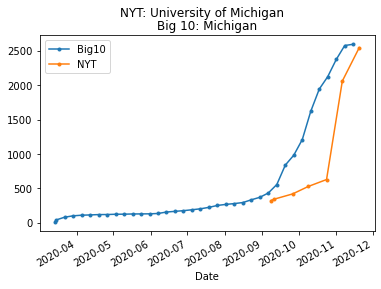

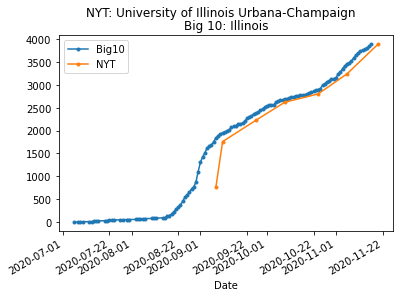

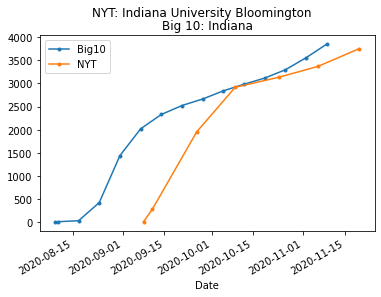

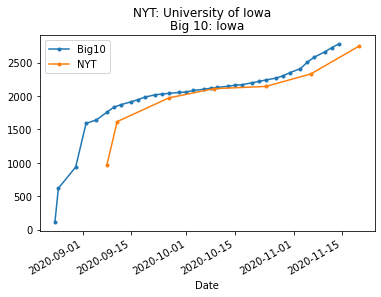

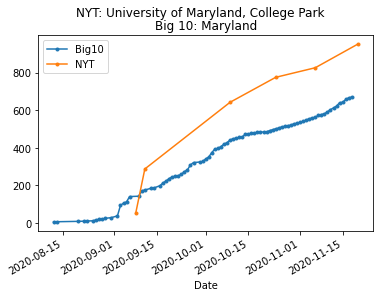

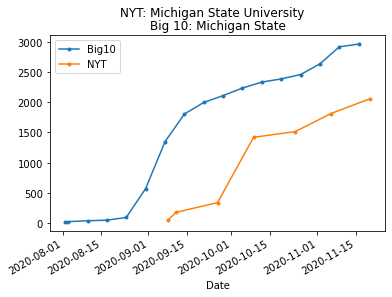

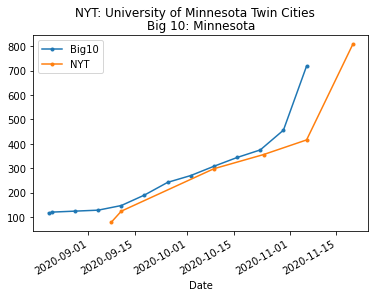

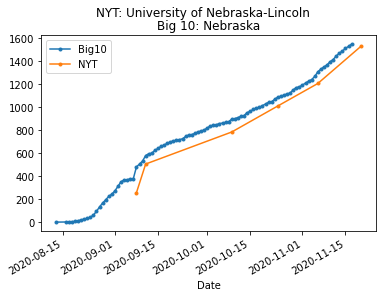

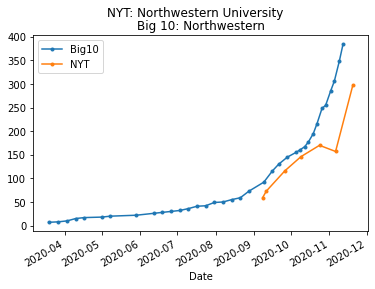

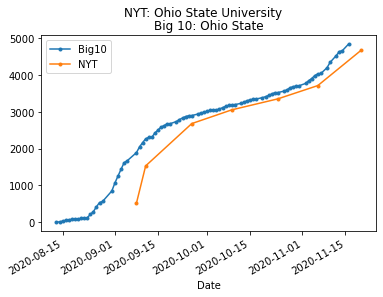

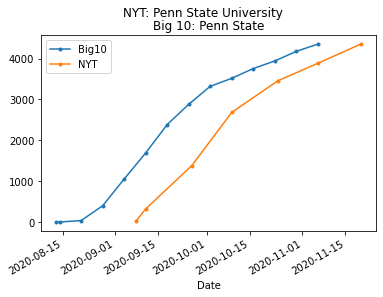

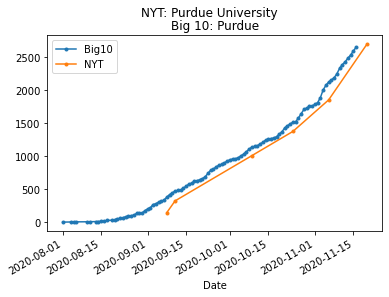

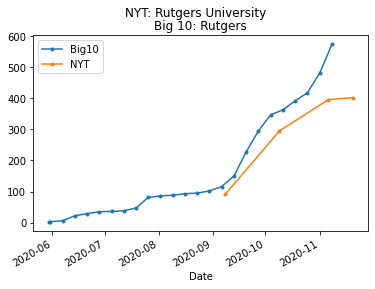

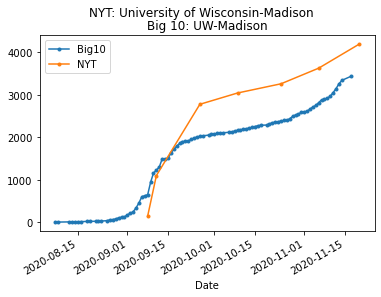

In [28]:
for b10_name, nyt_name in [('Michigan', 'University of Michigan'), 
                           ('Illinois', 'University of Illinois Urbana-Champaign'),
                           ('Indiana', 'Indiana University Bloomington'),
                           ('Iowa', 'University of Iowa'),
                           ('Maryland', 'University of Maryland, College Park'),
                           ('Michigan State', 'Michigan State University'),
                           ('Minnesota', 'University of Minnesota Twin Cities'),
                           ('Nebraska', 'University of Nebraska-Lincoln'),
                           ('Northwestern', 'Northwestern University'),
                           ('Ohio State', 'Ohio State University'),
                           ('Penn State', 'Penn State University'),
                           ('Purdue', 'Purdue University'),
                           ('Rutgers', 'Rutgers University'),
                           ('UW-Madison', 'University of Wisconsin-Madison')]:
    fig, ax = plt.subplots(1)
    big10_df.loc[b10_name]['Confirmed'].plot(style = '.-', ax = ax, label = 'Big10')
    nyt_df.loc[nyt_name]['Cases'].plot(style = '.-', ax = ax, label = 'NYT')
    plt.suptitle('NYT: {}'.format(nyt_name))
    plt.title('Big 10: {}'.format(b10_name))
    plt.legend(loc = 'best')

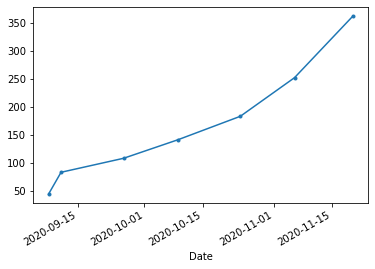

In [29]:
nyt_df.loc['Boston University']['Cases'].plot(style = '.-', label = 'NYT')

In [30]:
nyt_df.loc['University of Wisconsin-Madison']

,Cases,County_Active_Cases,County_Total_Cases,City,County,State
Date,,,,,,
2020-09-08,145,6387.0,6427.0,Madison,Dane,Wisconsin
2020-09-11,1097,7213.0,7254.0,Madison,Dane,Wisconsin
2020-09-26,2775,9447.0,9488.0,Madison,Dane,Wisconsin
2020-10-09,3041,10992.0,11035.0,Madison,Dane,Wisconsin
2020-10-24,3258,13783.0,13831.0,Madison,Dane,Wisconsin
2020-11-06,3626,17754.0,17807.0,Madison,Dane,Wisconsin
2020-11-20,4193,NaN,NaN,Madison,NaN,Wisconsin


In [31]:
big10_df.loc['UW-Madison']

,Tests,Confirmed
Date,,
2020-08-07,40.0,1
2020-08-08,72.0,2
2020-08-12,208.0,6
2020-08-13,322.0,7
2020-08-14,579.0,8
...,...,...
2020-11-11,103372.0,3052
2020-11-12,105791.0,3146
2020-11-13,108877.0,3258


big10 is reporting (students + employees), on campus.   NYT is reporting students, on and off campus.

In [75]:
turk_df = pd.read_csv('../MTurk_Data/turk11_19_2020.csv')
turk_df['Date'] = pd.to_datetime('2020-11-20',format='%Y-%m-%d')
Cases = turk_df['CumulativeCases'].copy()
Cases[turk_df['CumulativeCases'] == 'No agreed upon value'] = np.nan
turk_df['CumulativeCases'] = Cases.astype('float')
turk_df.index = pd.MultiIndex.from_frame(turk_df[['SchoolName', 'Date']])
turk_df.drop(['SchoolName', 'Unnamed: 0', 'Date'], axis = 1, inplace = True)

In [76]:
turk_df['CumulativeCases']

SchoolName                       Date      
American University              2020-11-20      35.0
Auburn University                2020-11-20    1467.0
Augustana College                2020-11-20       NaN
Ball State University            2020-11-20    1283.0
Bard College                     2020-11-20       1.0
                                                ...  
William Paterson University      2020-11-20      48.0
Williams University              2020-11-20      10.0
Wooster                          2020-11-20     130.0
Worcester Polytechnic Institute  2020-11-20      38.0
Yale                             2020-11-20     248.0
Name: CumulativeCases, Length: 171, dtype: float64

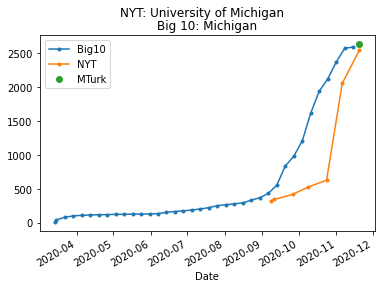

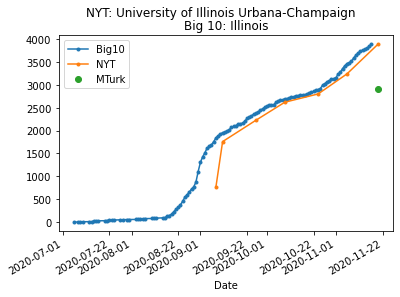

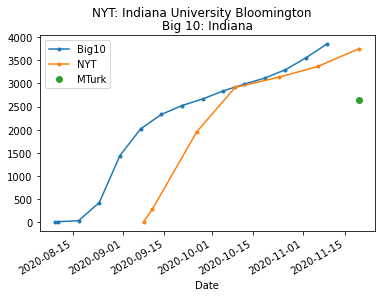

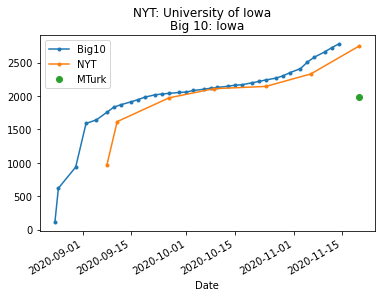

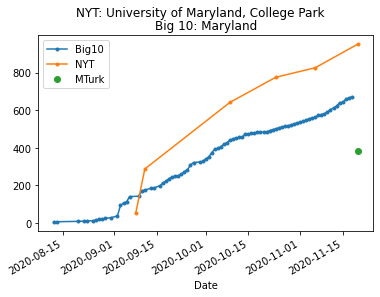

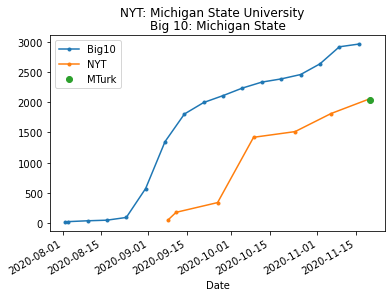

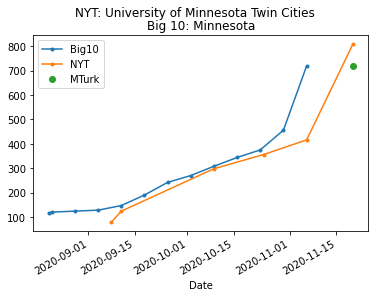

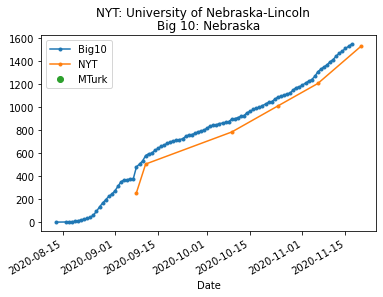

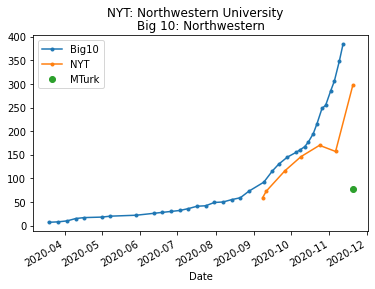

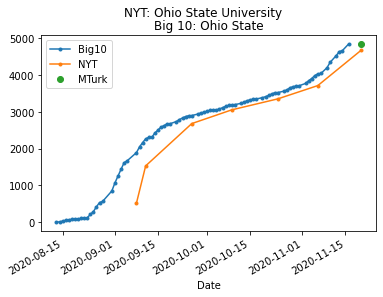

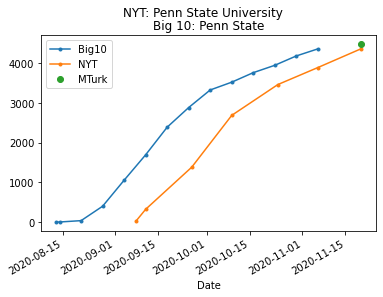

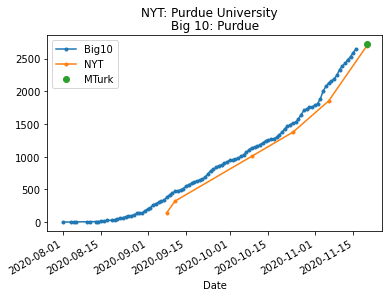

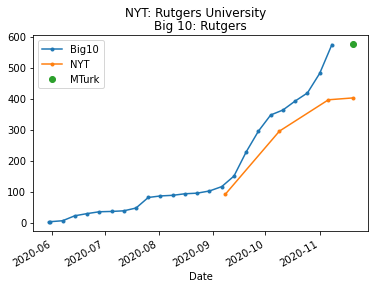

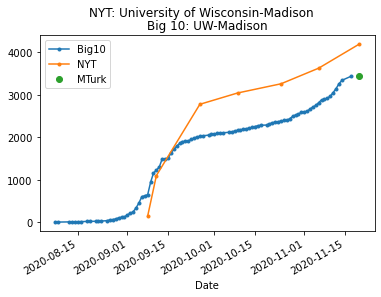

In [83]:
for b10_name, nyt_name, turk_name in [('Michigan', 'University of Michigan', 'University of Michigan'), 
                           ('Illinois', 'University of Illinois Urbana-Champaign', 'University of Illinois Urbana Champaign '),
                           ('Indiana', 'Indiana University Bloomington', 'Indiana University'),
                           ('Iowa', 'University of Iowa', 'University of Iowa'),
                           ('Maryland', 'University of Maryland, College Park', 'University of Maryland'),
                           ('Michigan State', 'Michigan State University', 'Michigan State University'),
                           ('Minnesota', 'University of Minnesota Twin Cities', 'University of Minnesota'),
                           ('Nebraska', 'University of Nebraska-Lincoln', 'University of Nebraska-Lincoln'),
                           ('Northwestern', 'Northwestern University', 'Northwestern University'),
                           ('Ohio State', 'Ohio State University', 'Ohio State University'),
                           ('Penn State', 'Penn State University', 'Penn State University'),
                           ('Purdue', 'Purdue University', 'Purdue University'),
                           ('Rutgers', 'Rutgers University', 'Rutgers University'),
                           ('UW-Madison', 'University of Wisconsin-Madison', 'University of Wisconsin Madison')]:
    fig, ax = plt.subplots(1)
    big10_df.loc[b10_name]['Confirmed'].plot(style = '.-', ax = ax, label = 'Big10')
    nyt_df.loc[nyt_name]['Cases'].plot(style = '.-', ax = ax, label = 'NYT')
    turk_df.loc[turk_name]['CumulativeCases'].plot(style = 'o', ax = ax, label = 'MTurk')
    plt.suptitle('NYT: {}'.format(nyt_name))
    plt.title('Big 10: {}'.format(b10_name))
    plt.legend(loc = 'best')